# Activity 3.1 Perceptron
(last modified 27 Mar 2023)

### Learning Outcomes

In this activity, you learn how to 

- generate synthetic Gaussian mixture data to test classification algorithms
- implement the Perceptron algorithm
- evaluate and describe weaknesses of the Perceptron
- compute and plot the decision boundary for 2-dimensional input data
- modify linear classification algorithms to allow for an affine decision boundary (one that does not run through the origin)

In you Assignment, you will be asked to expand the Perceptron algorithm to multi-class classification problems.

### Prerequisites

- Module 1
- Lecture 5

## Synthetic Data for Classification

In this and other activities of Module 3, we again work with synthetic data generators, which makes it easier to study the model we develop and validate the obtained results. In particular, we are working **Gaussian mixture models** where the input data for each class follows a (multivariate) Gaussian distribution and the classes follow marginal some categorical distribution. Formally, we can define the distribution of our target variable $T \in \{0, 1, \dots, k-1\}$ and our input variable(s) $X \in \R^p$ as
\begin{align*}
T &\sim \mathrm{Cat}(\varphi_1, \dots, \varphi_k)\\
X | T &\sim N_p(\boldsymbol{\mu}_T, \Sigma_T)
\end{align*}
where $\varphi_1, \dots, \varphi_k \in [0, 1]^k$ are the marginal class probalities with $\sum_{l=1}^{k}\varphi_l = 1$ and for each $l \in \{1, \dots, k\}$, $\boldsymbol{\mu}_l \in \R^p$ and $\boldsymbol{\Sigma}_l \in \R^{p \times p}$ are the mean vector and the covariance matrix of the inputs with class $l$.

Don't worry if you don't yet know about the multivariate Gaussian distribution. We will talk more about it next week. In particular, in this activity we will work with unit covariance matrices in two dimensions, i.e.,
\begin{equation*}
\Sigma = 
\begin{pmatrix}
1 & 0\\
0 & 1\\
\end{pmatrix}
\end{equation*}
which means that the two input variables $X=(X_1, X_2)$ are independent and normally distributed according,
$$X_i | T \sim N(\mu_{T, i}, 1)$$

Concretely, in this activity we are working with the following parameters:
- the marginal class probabilities are $(\phi_1, \phi_2)=(0.6, 0.4)$
- the mean vector of the input variables for class $1$ is $(3.5, 2.5)$, i.e., $X_1 | T = 1 \sim N(3.5, 1)$ and $X_2 | T = 1 \sim N(2.5, 1)$
- the mean vector of the input variables for class $2$ is $(0, 6)$, i.e., $X_1 | T = 2 \sim N(0, 1)$ and $X_2 | T = 2 \sim N(6, 1)$

Let us implement this distribution and draw and plot some training data to get an intuition about it.

In [2]:
import numpy as np

def make_gaussian_mixture_data(n, means, covs=None, class_probs=None, random_state=None):
    RNG = np.random.default_rng(seed=random_state)
    d = len(means[0])
    k = len(means)

    # sample outputs
    # if no class probabilities are provided, assume uniform
    class_probs=np.ones(k)/k if class_probs is None else class_probs

    # generate the y-sample using a multinomial distribution with 'number of experiments' equal to 1;
    # this results in a categorical distribution
    # the output of multinomial is a n times x binary matrix with a single 1-entry per row indicating
    # what class that row belongs to; we map this to the numbers 0 to (k-1) with np.nonzero
    _, y = np.nonzero(RNG.multinomial(1, class_probs, size=n))

    # sample inputs conditioned on outputs
    # if no covariances are provided assume unit
    covs = [np.eye(d) for _ in range(k)] if covs is None else covs
    x = np.zeros(shape=(n, d))
    for i in range(k):
        idx_i = np.flatnonzero(y==i)
        x[idx_i] = RNG.multivariate_normal(means[i], covs[i], size=len(idx_i))

    return x, y

p0 = 0.60; p1 = 1 - p0
class_probs = [p0, p1] 
mu0 = np.array([3.5, 2.5])
mu1 = np.array([0.0, 6.0])

make_gaussian_mixture_data(10, [mu0, mu1], class_probs=class_probs, random_state=0)

(array([[ 0.41163054,  7.04251337],
        [ 2.87672554,  2.54132598],
        [ 1.17496923,  2.28120834],
        [ 2.25408905,  1.76773265],
        [-0.12853466,  7.36646347],
        [-0.66519467,  6.35151007],
        [ 0.90347018,  6.0940123 ],
        [-0.74349925,  5.07827462],
        [ 2.95574102,  2.18369984],
        [-0.45772583,  6.22019512]]),
 array([1, 0, 0, 0, 1, 1, 1, 1, 0, 1]))

#### Task A: Generate and Plot Training Data

Let us generate 100 training data points and plot them in a scatter plot using a different color for each class. Most of the code for this is already complete. We just need to select the individual columns and, for each call of `scatter`, the rows that belong to one specific class.

**Complete the two lines below to select the indiviudal data columns `0` and `1` and within those only the data points of the specific class `c`**

Hint: Remember how you can use indexing with a `numpy.ndarray` to select parts of the array

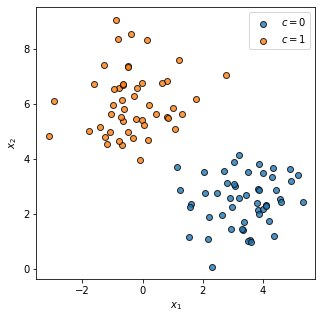

In [3]:
import matplotlib.pyplot as plt

def scatter_data_by_target_value(x, y, ax=None, scatter_params={'ec': 'black', 'alpha': 0.8}):
    ax = plt.gca() if ax is None else ax
    for c in range(2):
        x1_c = x[y==c, 0]
        x2_c = x[y==c, 1]
        ax.scatter(x1_c, x2_c, label=f'$c={c}$', **scatter_params)
    ax.legend()
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

n = 100
x_train, y_train = make_gaussian_mixture_data(n, [mu0, mu1], class_probs=class_probs, random_state=0)

plt.figure(figsize=(5, 5))
scatter_data_by_target_value(x_train, y_train)
plt.show()

##  The Perceptron

As introduced in the lecture, the Perceptron is a linear predictive model for binary classification with parameters $\boldsymbol{w} \in \R^p$ defining a **prediction function**
$$
y(\boldsymbol{x}, \boldsymbol{w}) = 
\begin{cases}
1 &, \text{ if }\boldsymbol{w}^T\boldsymbol{x} \geq 0\\
0 &, \text{ otherwise}
\end{cases}
$$
which can also be written as $y(\boldsymbol{w}^T\boldsymbol{x})=f(\boldsymbol{w}^T\boldsymbol{x})$ using the non-linear step function 
$$
f(a) = 
\begin{cases}
1 &, \text{ if }a \geq 0\\
0 &, \text{ otherwise}
\end{cases}
$$
as **activation function**.

The **Perceptron algorithm** for fitting the weights $\boldsymbol{w}$ is an early iterative learning algorithm that can be considered a variant of stochastic gradient descent with batch size $1$. It can be semi-formally described as:

- repeat until small training error or maximum number of weight updates reached
    - for each training data point $(x_n, t_n)$ (in random order)
        - if $y(x_n)\neq t_n$ then $w \leftarrow w + (2t_n - 1) \eta x_n$

where $\eta > 0$ is some appropriately chosen learning rate (like in stochastic gradient descent.)

Note that the formula $2t_n - 1$ is just a compact way to write the case distinction
$$
w \leftarrow
\begin{cases}
w + \eta x_n &, \text{ if } t_n = 1\\
w - \eta x_n &, \text{ if } t_n = 0
\end{cases} \\
$$
that is useful to keep the code simple.

Below is an almost finished implementation of the algorithm. Note that as in our implementation of stochastic gradient descent, we are tracking the full history of the weight vectors for the purpose of visualisation. In addition, we are also tracking the order in which the training examples are considered during training.

#### Task B: Implement Predict

**Fill in the code for `predict` below that implements $y(\boldsymbol{x}, \boldsymbol{w})$ based on the weights `self.w_` that have been set by the `fit` method.**

Hints:
- Remember that, in `numpy` we can conveniently compute componentwise comparisons with a constant, e.g., `a < 5` computes a boolean array that contains the results of comparing all entries of `a` with `5` (try it out if this is unclear).
- You can typecase arrays with the method `astype`; here we want integer (`int`) predictions instead of `bool` values

In [4]:
class Perceptron:
    
    def __init__(self, eta=0.01, tau_max=10000, epsilon=0.005, random_state=None):
        self.eta = eta   # learning rate
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon   # tolerable error
        self.random_state = random_state

    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape

        self.w_trace_ = np.empty((self.tau_max, p))     # trace of weights during training
        self.xy_idx_trace_ = np.empty(self.tau_max, int) # trace of considered training point indices
        
        # initialisation of iteration counter and weights
        tau = 0 
        self.w_ = self.w_trace_[0,:] = RNG.normal(size=p) 
        terminate = False
        while not (terminate or (self.predict(x)!=y).mean()<self.epsilon):
            # random order to consider training data
            order = RNG.choice(np.arange(n),size = n ,replace = False)
            for i in range(n):
                if self.predict(x[order][i]) != y[order][i]:
                    self.w_ = self.w_ + (2*y[order][i]-1)*self.eta * x[order][i]
                
                self.w_trace_[tau+1] = self.w_
                self.xy_idx_trace_[tau] = order[i]

                tau +=1
                if tau == self.tau_max-1:
                    terminate = True
                    break
        
        # remove empty rows from traces
        self.w_trace_ = self.w_trace_[:tau] 
        self.xy_idx_trace_ = self.xy_idx_trace_[:tau-1]

        return self

    def predict(self, x):
        return (x.dot(self.w_) >= 0).astype(int)


Now we initialise and train the perceptron with our training data.

In [5]:
perceptron = Perceptron(random_state=0)
perceptron.fit(x_train, y_train)

As usual, let us first look at train and test performance. For the test performance, we can just generate a lot of new data points, exploiting the fact that we have a synthetic data generator.

#### Task C: Check Train and Test Performance.

Hint: You can use `zero_one_loss` from `sklearn.metrics` or simply compute the mean zero/one error using numpy.

In [6]:
from sklearn.metrics import zero_one_loss

x_test, y_test = make_gaussian_mixture_data(n=1000, means=[mu0, mu1])

train_error = zero_one_loss(perceptron.predict(x_train), y_train)
test_error = zero_one_loss(perceptron.predict(x_test), y_test)

train_error, test_error

(0.020000000000000018, 0.007000000000000006)

## Investigate Learned Decision Boundary

Let us now visualise the **decision boundary** that the Perceptron has learned, i.e., the hyperplane (a line in the case of 2d-data) of $\boldsymbol{x}$-values where 
$$
\boldsymbol{w}^T\boldsymbol{x}= w_1x_1 + w_2x_2 =0 \enspace .
$$
Below we already give a function that can plot a line in matplotlib given in the form $y=ax + b$, i.e., where the $y$-coordinate in the plot is given as a linear function of the $x$-coordinate with a slope $a$ and intercept $b$. To use this function we have to express our decision boundary in this form.

#### Task D: Express decision boundary as function $x_2 = ax_1 + b$

**Describe the representation in markdown below (or using pen and paper) and implement it in the next code cell.**

Hint: The $y$-coordinate in the plot is the $x_2$-coordinate of our input data and the $x$-coordinate in the plot is the $x_1$-coordinate of our input data.

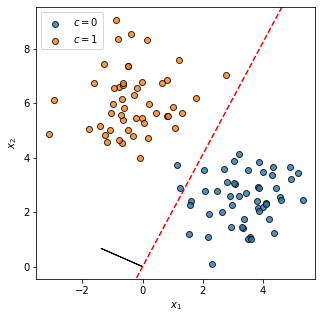

In [7]:
def plot_line(slope, intercept, ax=None, shape='--', **kwargs):
    ax = plt.gca() if ax is None else ax
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_xlim())
    ax.plot(x_vals, y_vals, shape, **kwargs)

def plot_decision_boundary_from_weights(weights, ax=None):
    slope = -weights[0]/weights[1]
    intercept = 0
    plot_line(slope, intercept, ax, shape='--', color='red')

plt.figure(figsize=(5, 5))
scatter_data_by_target_value(x_train, y_train)
plt.arrow(0, 0, *(perceptron.w_*5))
plot_decision_boundary_from_weights(perceptron.w_)
plt.show()

## Analysis of Perceptron Learning

Next, let us have a look at the learning process of the Perceptron algorithm as captured by the sequence of weight vectors that are attained during training. Let us plot both, the development of the weights as well as that of the training and test errors.

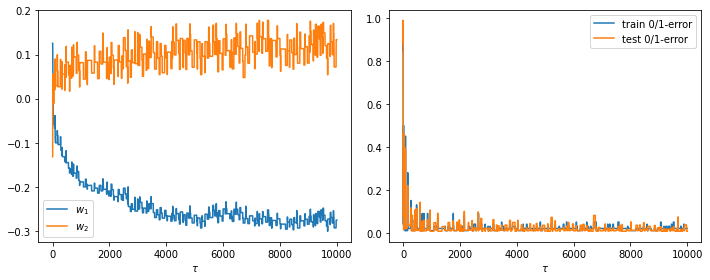

In [8]:
test_errors = np.array([zero_one_loss((x_test.dot(w)>=0), y_test) for w in perceptron.w_trace_])
train_errors = np.array([zero_one_loss((x_train.dot(w)>=0), y_train) for w in perceptron.w_trace_])

_, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
axs[1].plot(train_errors, label='train 0/1-error')
axs[1].plot(test_errors, label='test 0/1-error')
axs[1].set_xlabel(r'$\tau$')
axs[1].legend()
axs[0].plot(perceptron.w_trace_[:, 0], label='$w_1$')
axs[0].plot(perceptron.w_trace_[:, 1], label='$w_2$')
axs[0].set_xlabel(r'$\tau$')
axs[0].legend()
plt.show()


#### Task E: Comment on Learning Behaviour

**Give a one paragraph summary on what you observe about the learning behaviour. Is there something you are concerned about? How could we potentially improve the Perceptron learning?**

Hint: For the last question, you might also want to investigate the next illustration.

*The learning does not seem to converge. The weights are fluctuating around an apparent error minimiser, likely because the data cannot be linearly seperated with a hyperplane through the origin. Hence, an improvement would be to add a bias weight in a feature transformation to allow the decision boundary to not pass throught the origin.*



To further analyse the learning, let us pick one training update during which the training error became worse and plot the corresponding decision boundaries.

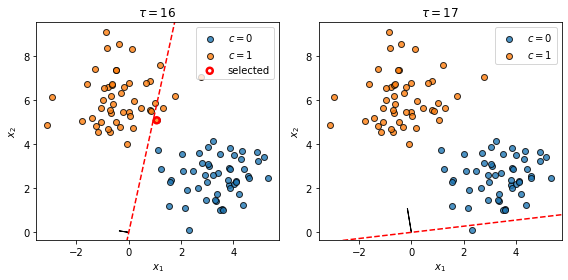

In [9]:
train_error_diffs = train_errors[:-1] - train_errors[1:]
min_idx = np.argmin(train_error_diffs)
min_idx, train_errors[min_idx: min_idx+2]

_, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
axs[0].set_title(f'$\\tau={min_idx}$')
scatter_data_by_target_value(x_train, y_train, axs[0])
axs[0].scatter(x_train[perceptron.xy_idx_trace_[min_idx], 0], x_train[perceptron.xy_idx_trace_[min_idx], 1], ec='red', fc='none', lw=2.5, label='selected')
plot_decision_boundary_from_weights(perceptron.w_trace_[min_idx], axs[0])
axs[0].arrow(0, 0, *(perceptron.w_trace_[min_idx]*20))
axs[0].legend()
axs[1].set_title(f'$\\tau={min_idx+1}$')
scatter_data_by_target_value(x_train, y_train, axs[1])
plot_decision_boundary_from_weights(perceptron.w_trace_[min_idx+1], axs[1])
axs[1].arrow(0, 0, *(perceptron.w_trace_[min_idx+1]*20))
plt.show()


## Improving the Perceptron

You might recognise as one improvement strategy to increase the flexibility of the model by allowing the decision boundary not to pass through the origin. Technically, this is done by introducing a **bias weight** $w_0$ and to modify the prediction function to
$$
y(\boldsymbol{x}, \boldsymbol{w}) = f(w_0 + w_1x_1 + w_2x_2)
$$
where $f$ denotes again our step activation function.

Instead of modifying our Perceptron implementation, we can achieve this with the simple input transformation of adding a constant 1-term to the input vector:
$$
\boldsymbol{\phi}(\boldsymbol{x})=(1, x_1, x_2, \dots, x_p) .
$$

As we have learned previously, we can combine this input transformation with the Perceptron into a pipeline that implements the desired overal model. For that, we could implement the transformation in the transformer framework (with methods `fit` and `transform`) or simply re-use the `PolynomialFeatures` transformer where we set the order to $1$, observing that the order $0$ feature is exactly the constant $1$ feature and the order $1$ features are our original inputs.

In [10]:
from sklearn.preprocessing import PolynomialFeatures

add_constant = PolynomialFeatures(1)
add_constant.fit_transform(x_train)[:5]

array([[ 1.        , -0.6635352 ,  5.38658215],
       [ 1.        ,  2.15878029,  1.09847979],
       [ 1.        ,  4.00268285,  3.48971303],
       [ 1.        ,  3.33570541,  1.42563514],
       [ 1.        , -1.6051494 ,  6.7293494 ]])

#### Task F: Build Pipeline implementing Perceptron with Intercept

**Complete the line below**

In [15]:
from sklearn.pipeline import make_pipeline

perceptron_with_intercept = make_pipeline(PolynomialFeatures(1), Perceptron(random_state=0))
perceptron_with_intercept.fit(x_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('perceptron', <__main__.Perceptron object at 0x131821520>)])

In [16]:
perceptron_part = perceptron_with_intercept.steps[1][1]
perceptron_part.w_, len(perceptron_part.w_trace_)

(array([-0.29426978, -0.37730263,  0.19140322]), 5100)

In [17]:
zero_one_loss(perceptron_with_intercept.predict(x_train), y_train), zero_one_loss(perceptron_with_intercept.predict(x_test), y_test)

(0.0, 0.014000000000000012)

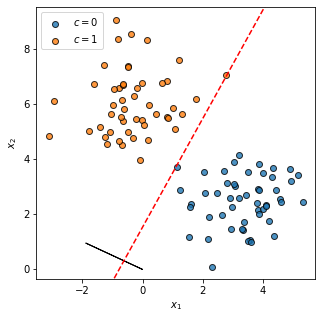

In [18]:
def plot_decision_boundary_from_weights_with_intercept(w, ax=None):
    slope = -w[1]/w[2]
    intercept = -w[0]/w[2]
    plot_line(slope, intercept, ax, shape='--', color='red')

plt.figure(figsize=(5, 5))
scatter_data_by_target_value(x_train, y_train)
plot_decision_boundary_from_weights_with_intercept(perceptron_part.w_)
plt.arrow(0, 0, *perceptron_part.w_[1:]*5)
plt.show()


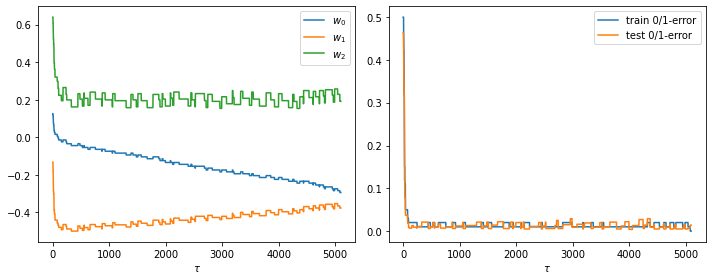

In [19]:
model = perceptron_with_intercept.steps[1][1]
test_errors = np.array([zero_one_loss((add_constant.transform(x_test).dot(w)>=0), y_test) for w in model.w_trace_])
train_errors = np.array([zero_one_loss((add_constant.transform(x_train).dot(w)>=0), y_train) for w in model.w_trace_])

_, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
axs[1].plot(train_errors, label='train 0/1-error')
axs[1].plot(test_errors, label='test 0/1-error')
axs[1].set_xlabel(r'$\tau$')
axs[1].legend()
axs[0].plot(model.w_trace_[:, 0], label='$w_0$')
axs[0].plot(model.w_trace_[:, 1], label='$w_1$')
axs[0].plot(model.w_trace_[:, 2], label='$w_2$')
axs[0].set_xlabel(r'$\tau$')
axs[0].legend()
plt.show()


## Task G: Discussion

Even with the improvement of adding a bias term, the Perceptron learning seems to be not fully satisfactory. 

**Make a list of problems that you see even with the improved version and give potential stragegies to address those**.

- *Now the Perceptron found weights with zero training error but it took a lot of iterations to get there.*
- *If the data is not linearly separable even with a shifted line the algorithm could still oscilate around a minimum and the quality of the final fit will be unstable as it depends on the setting of the max number of iterations.*
- *The final fit still does not seem optimal in the sense that the closest training points to the decision boundary could be further away as to increase the conviction of the prediction.*

*These problems could probably be addressed by switching to a smoother convex error function (or ideally likelihood function) that considers the distance of all points to the decision boundary and has a uninque minimum. With this the more principled gradient descent algorithm could be used to guarantee smooth convergence.*